# Import

In [1]:
# Import package
# Outside package
import numpy as np
import scipy.io as sio
from itertools import count

import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI-LSTM')

# Inner package
from src.RL_functions.helpers import *
from src.RL_functions.kalman import *
from src.gym_kalman.env_revised_rewards import *
from src.RL_functions.dqn_agent import *
from src.RL_functions.evaluation import *

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Import data
time_series_path = './data/HQ/CASC_LGA_LGABAR_LGA007PIAP-E010_Comb_2311_weekly.mat'

# Load data
data = sio.loadmat(time_series_path)
# real_timestamps = data['timestamps'].T[0]
# real_observations = data['values'].T[0]

real_timestamps = data['values'][:, 1][0].T[0]
real_observations = data['values'][:, 3][0].T[0]

# convert the list of int32 to float64
real_timestamps = real_timestamps.astype('float64')

In [3]:
# # Remove
remove_index = 574
# Delete all the entries after the remove_index
real_timestamps = np.delete(real_timestamps, np.s_[:remove_index])
real_observations = np.delete(real_observations, np.s_[:remove_index])

# Data processing

In [4]:
frequency = 'W'
ts_processor = DataProcessor()
resample_timestamps, resample_observations = ts_processor.resample_time_series(matlab_datenum=real_timestamps, \
                                                                            observations=real_observations, \
                                                                            frequency=frequency)

# resample_timestamps = resample_timestamps[:215]
# resample_observations = resample_observations[:215]

<class 'numpy.float64'>


### Check point

================== Summary of imported time series data ==================
Most frequent time step interval:             7.0
Number of total real observations:            722
Number of missing data in real observation:   10
Number of total resampled observations:       722
Number of missing data in real observation:   10
Plot:


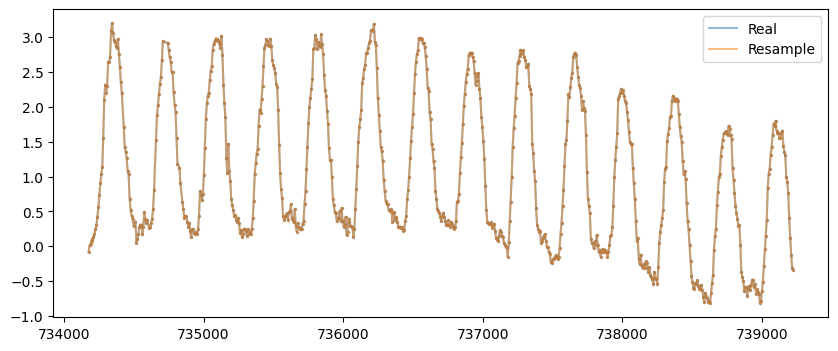

In [5]:
# Data summary
summarize_time_series(real_timestamps, real_observations, resample_timestamps, resample_observations)

# Define models

In [6]:
# Kalman filter model definition
time_step = 1           # Refer to 'Summary of imported time series data' for the reference time step
components = ['autoregressive_acceleration', 'kernel', 'ar']
# Optimal parameters using 270 points
hyperparameters = {'autoregressive_acceleration': {'process_error_var': 0.0, 'phi': 0.999, 'LA_process_error_var': 0.11453**2*1e-17 },
                   'kernel': {'period': 365.2422/7, 'kernel_length': 0.58491, 'sigma_KR0': 0, 'sigma_KR1': 0, 'n_cp':10},
                   'ar': {'phi': 0.75867, 'process_error_var': 0.11453**2},
                   'observation': {'error': 1e-6}}
LA_var_stationary = hyperparameters['autoregressive_acceleration']['LA_process_error_var']/(1-hyperparameters['autoregressive_acceleration']['phi']**2)

x_init = {'mu': np.array([1.37, -1.19E-05, 0, 0, -1.2, -0.822, -2.01, 0.292, 1.68, 1.85, 1.96, 0.568, -1.44, -0.88, -0.516]), \
          'var': np.diag([0.111, 2.88E-09, LA_var_stationary, 1.1, 0.278, 0.273, 0.276, 0.281, 0.284, 0.288, 0.284, 0.283, 0.282, 0.281, 0.0346]),\
          'var_stabilized': np.diag([0.111, 2.88E-09, LA_var_stationary, 1.1, 0.278, 0.273, 0.276, 0.281, 0.284, 0.288, 0.284, 0.283, 0.282, 0.281, 0.0346])}

In [7]:
# Reinforcement learning model definition
step_look_back = 64     # How many steps the RL agents look back in the estimate history

# Parameters relative to the trainig of Q-Network
BATCH_SIZE = 128
GAMMA = 0.99            # discount factor
EPS_START = 0.9         # greedy policy
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005             # for soft update of target parameters
LR = 1e-4               # learning rate

### Check point

In [8]:
# Check if the KF and RL models are correctly defined
num_steps = 5000        # Refer to 'Summary of imported time series data' for the reference time step
syn_ts = generate_time_series(components = components,\
                              time_step = time_step, \
                              hyperparameters = hyperparameters,\
                              num_steps = num_steps, \
                              x_init = x_init,\
                              insert_anomaly = False)

i_ts_datasets = {
    'measurement': syn_ts['y'],
    'timestamps': syn_ts['timesteps'],
    'time_step': time_step,
    'components': components,
    'hyperparameters': hyperparameters,
    'initial_states': x_init,
}

env = KalmanInterventionEnv(render_mode=None, time_series_datasets=i_ts_datasets, step_look_back = step_look_back, \
                            hyperparameters=hyperparameters)

state, _ = env.reset(mode = 'get_stabilized_var')
for i in range(num_steps - step_look_back - 1):
    if i == 4000 + step_look_back + 1:
        action = 0
    else:
        action = 0
    state, reward, _, _, info = env.step(action)

# =============================================================================
# Update the stabilized covariance
x_init['var_stabilized'] = info['hidden_states']['var'][-1]
syn_ts = generate_time_series(components = components,\
                                time_step = time_step, \
                                hyperparameters = hyperparameters,\
                                num_steps = num_steps, \
                                x_init = x_init,\
                                insert_anomaly = False,\
                                anomaly_timesteps = [int(num_steps/2)],\
                                anomaly_LT = [1e-2]
                                )

i_ts_datasets = {
    'measurement': syn_ts['y'],
    'timestamps': syn_ts['timesteps'],
    'time_step': time_step,
    'components': components,
    'hyperparameters': hyperparameters,
    'initial_states': x_init,
}

env = KalmanInterventionEnv(render_mode=None, time_series_datasets=i_ts_datasets, step_look_back = step_look_back, \
                            hyperparameters=hyperparameters)

state, _ = env.reset(mode = 'test')

for i in range(num_steps - step_look_back - 1):
    if i == 4000 + step_look_back + 1:
        action = 0
    else:
        action = 0
    state, reward, _, _, info = env.step(action)

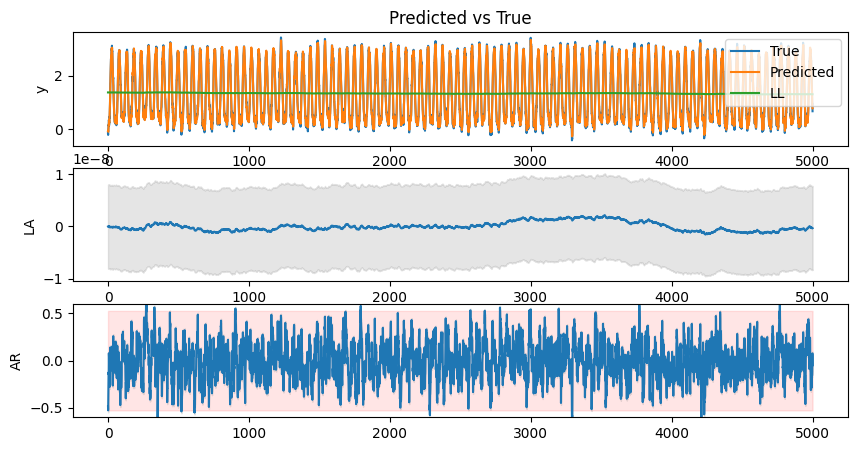

In [9]:
# Plot prediction
from matplotlib import gridspec
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(3, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

ax0.plot(syn_ts['timesteps'], syn_ts['y'], label='True')
ax0.plot(syn_ts['timesteps'], info['y_pred']['mu'], label='Predicted')
ax0.plot(syn_ts['timesteps'], info['hidden_states']['mu'][:,0], label='LL')
ax0.set_title('Predicted vs True')
ax0.set_ylabel('y')
ax0.legend()

ax1.plot(syn_ts['timesteps'], info['hidden_states']['mu'][:,2], label='LA')
ax1.fill_between(syn_ts['timesteps'], info['hidden_states']['mu'][:,2] - np.sqrt(info['hidden_states']['var'][:,2,2]),\
                    info['hidden_states']['mu'][:,2] + np.sqrt(info['hidden_states']['var'][:,2,2]), color='gray', alpha=0.2)

ax1.set_ylabel('LA')

AR_var_stationary = hyperparameters['ar']['process_error_var']/(1-hyperparameters['ar']['phi']**2)
ax2.fill_between(syn_ts['timesteps'], np.zeros_like(syn_ts['timesteps'])-3*np.sqrt(AR_var_stationary), np.zeros_like(syn_ts['timesteps'])+3*np.sqrt(AR_var_stationary), color='red', alpha=0.1)
ax2.plot(syn_ts['timesteps'], info['hidden_states']['mu'][:,-1], label='AR')
ax2.fill_between(syn_ts['timesteps'], info['hidden_states']['mu'][:,-1] - np.sqrt(info['hidden_states']['var'][:,-1,-1]),\
                    info['hidden_states']['mu'][:,-1] + np.sqrt(info['hidden_states']['var'][:,-1,-1]), color='gray', alpha=0.2)
ax2.set_ylabel('AR')
ax2.set_ylim(-0.6, 0.6)

plt.show()

coeff_one_episode= np.array(info['hidden_states']['var'][:,2,-1])/np.sqrt(info['hidden_states']['var'][:,2,2])/np.sqrt(info['hidden_states']['var'][:,-1,-1])[-1]

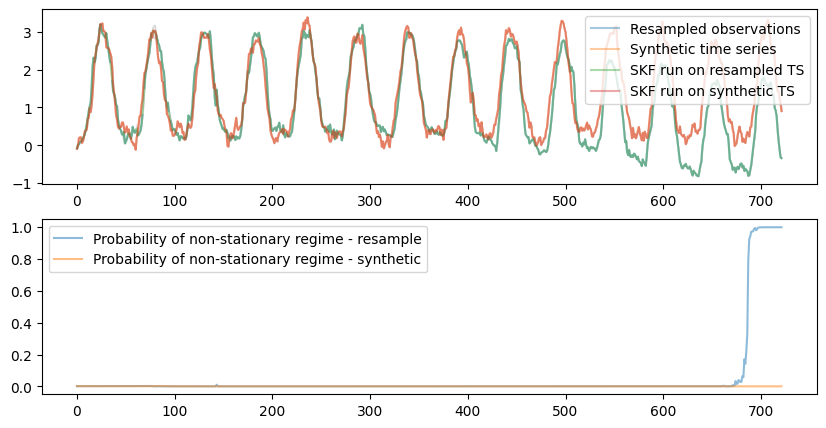

In [10]:
num_steps = 722        # Refer to 'Summary of imported time series data' for the reference time step
ts_model_check = generate_time_series(components = components,\
                                      time_step = time_step, \
                                      hyperparameters = hyperparameters,\
                                      num_steps = num_steps, \
                                      x_init = x_init,\
                                      insert_anomaly = False)

prob_ns_regime, y_mu, y_var, x_mu, x_var   = SKF_check(hyperparameters, x_init, ts_model_check['timesteps'], resample_observations, time_step_interval = time_step)
prob_ns_regime_syn, y_mu_syn, y_var_syn, _, _ = SKF_check(hyperparameters, x_init, ts_model_check['timesteps'], ts_model_check['y'], time_step_interval = time_step)


from matplotlib import gridspec
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(2, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.plot(ts_model_check['timesteps'], resample_observations, label='Resampled observations', alpha=0.4)
ax0.plot(ts_model_check['timesteps'], ts_model_check['y'], label='Synthetic time series', alpha=0.4)
ax0.plot(ts_model_check['timesteps'], y_mu, label='SKF run on resampled TS', alpha=0.4)
ax0.fill_between(ts_model_check['timesteps'], y_mu - np.sqrt(y_var), y_mu + np.sqrt(y_var), color='gray', alpha=0.2)
ax0.plot(ts_model_check['timesteps'], y_mu_syn, label='SKF run on synthetic TS', alpha=0.4)
ax0.fill_between(ts_model_check['timesteps'], y_mu_syn - np.sqrt(y_var_syn), y_mu_syn + np.sqrt(y_var_syn), color='gray', alpha=0.2)
ax0.legend()

ax1.plot(ts_model_check['timesteps'], prob_ns_regime, label='Probability of non-stationary regime - resample', alpha=0.5)
ax1.plot(ts_model_check['timesteps'], prob_ns_regime_syn, label='Probability of non-stationary regime - synthetic', alpha=0.5)
ax1.set_ylim([-0.05, 1.05])
ax1.legend()

plt.show()

#### Kalman-gym environment check

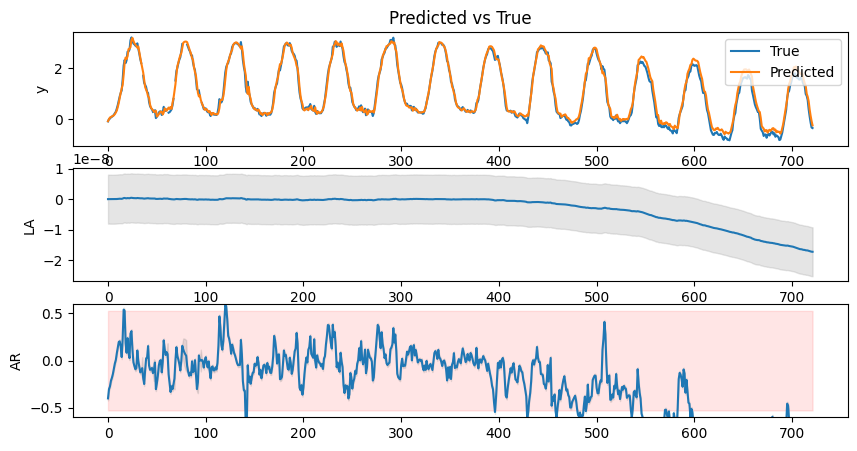

In [11]:
num_steps = len(ts_model_check['timesteps'])

# Set the dataset for the environment
dummy_ts_datasets = {
            'measurement': resample_observations,
            'time_step': time_step,
            'timestamps': ts_model_check['timesteps'],
            'components': components,
            'hyperparameters': hyperparameters,
            'initial_states': x_init,
        }

# Create the environment
total_reward = 0
env = KalmanInterventionEnv(render_mode=None, time_series_datasets=dummy_ts_datasets, step_look_back = step_look_back, hyperparameters=hyperparameters, smoothing_length=0)

state, info = env.reset()
intervention_index =[]
intervention_taken = False
AR_std_stationary = np.sqrt(hyperparameters['ar']['process_error_var']/(1-hyperparameters['ar']['phi']**2))
if step_look_back == 64:
    seg_len = 8
for i in range(num_steps - step_look_back - 1):
    state = torch.tensor(state['KF_hidden_states'],\
                        dtype=torch.float32, device=device).unsqueeze(0)
    state = normalize_tensor_two_parts(state, 0, np.sqrt(LA_var_stationary),\
                                        0, AR_std_stationary, seg_len)
    action = 0

    state, reward, _, _, info = env.step(action)

# Plot prediction
from matplotlib import gridspec
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(3, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

ax0.plot(ts_model_check['timesteps'], resample_observations, label='True')
ax0.plot(ts_model_check['timesteps'], info['y_pred']['mu'], label='Predicted')
for i in intervention_index:
    ax0.axvline(x=ts_model_check['timesteps'][i], color='r', linestyle='--')
ax0.set_title('Predicted vs True')
ax0.set_ylabel('y')
ax0.legend()

ax1.plot(ts_model_check['timesteps'], info['hidden_states']['mu'][:,2], label='LA')
ax1.fill_between(ts_model_check['timesteps'], info['hidden_states']['mu'][:,2] - np.sqrt(info['hidden_states']['var'][:,2,2]),\
                    info['hidden_states']['mu'][:,2] + np.sqrt(info['hidden_states']['var'][:,2,2]), color='gray', alpha=0.2)
ax1.set_ylabel('LA')

AR_var_stationary = hyperparameters['ar']['process_error_var']/(1-hyperparameters['ar']['phi']**2)
ax2.fill_between(ts_model_check['timesteps'], np.zeros_like(ts_model_check['timesteps'])-3*np.sqrt(AR_var_stationary), np.zeros_like(ts_model_check['timesteps'])+3*np.sqrt(AR_var_stationary), color='red', alpha=0.1)
ax2.plot(ts_model_check['timesteps'], info['hidden_states']['mu'][:,-1], label='AR')
ax2.fill_between(ts_model_check['timesteps'], info['hidden_states']['mu'][:,-1] - np.sqrt(info['hidden_states']['var'][:,-1,-1]),\
                    info['hidden_states']['mu'][:,-1] + np.sqrt(info['hidden_states']['var'][:,-1,-1]), color='gray', alpha=0.2)
ax2.set_ylabel('AR')
ax2.set_ylim(-0.6, 0.6)
plt.show()

# Training

In [12]:
training_episodes = 200
anomaly_range = [-0.01, 0.01]
abnormal_ts_percentage = 0.5
plot_samples = True # Plot the samples where the agent identifies two anomalies

In [13]:
# Create environment
i_ts_datasets = {
    'measurement': ts_model_check['y'],
    'timestamps': ts_model_check['timesteps'],
    'time_step': time_step,
    'components': components,
    'hyperparameters': hyperparameters,
    'initial_states': x_init,
}

env = KalmanInterventionEnv(render_mode=None, time_series_datasets=i_ts_datasets, \
                            step_look_back = step_look_back, hyperparameters=hyperparameters, \
                            smoothing_length=0)
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state['KF_hidden_states'])

print('================== Environment information ==================')
print('Number of actions:', n_actions)
print('Number of observations:', n_observations)

================== Environment information ==================
Number of actions: 2
Number of observations: 16


<Figure size 640x480 with 0 Axes>

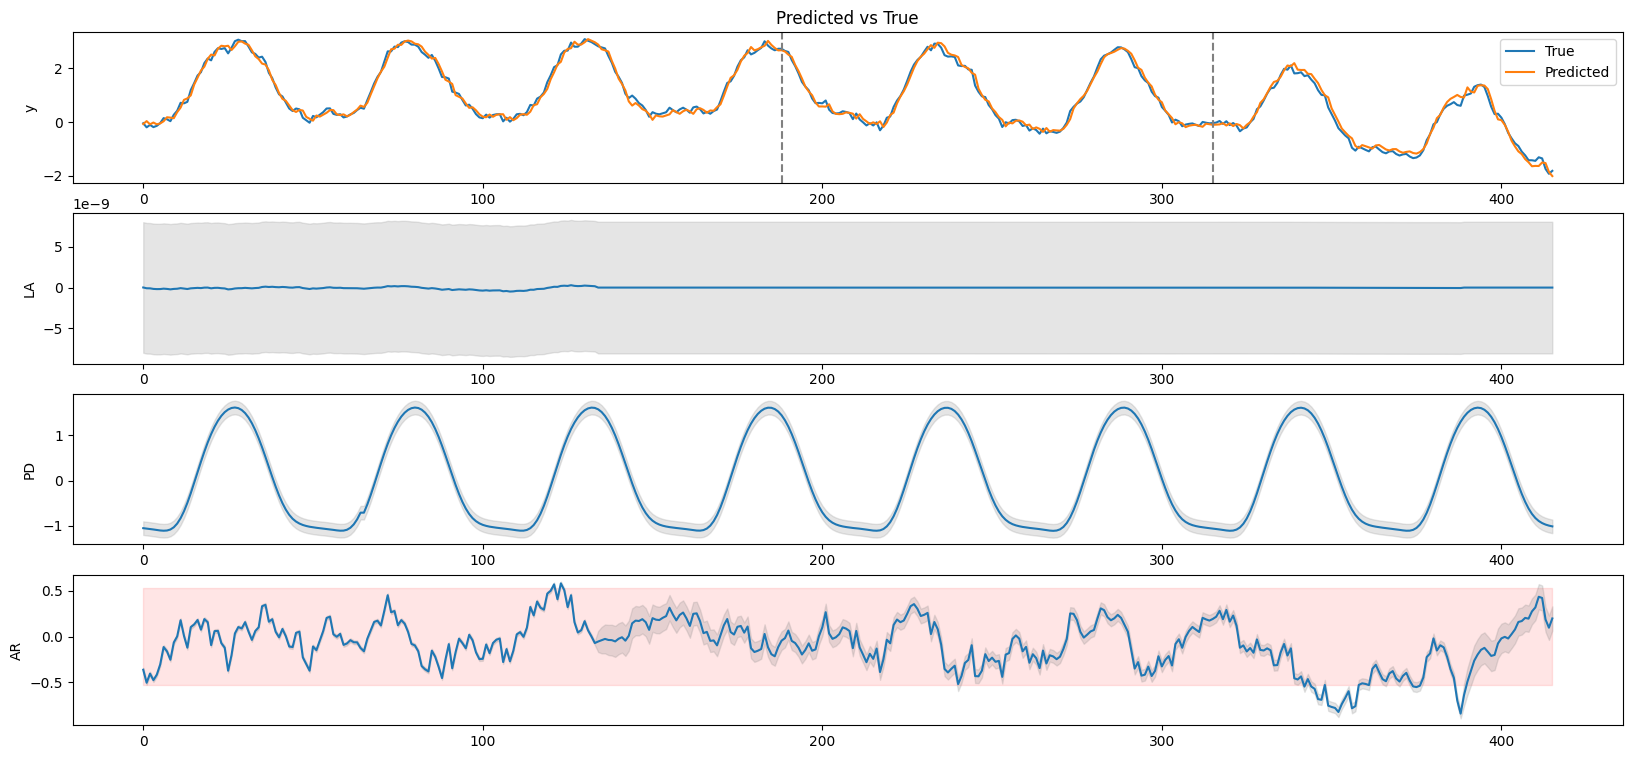

Complete


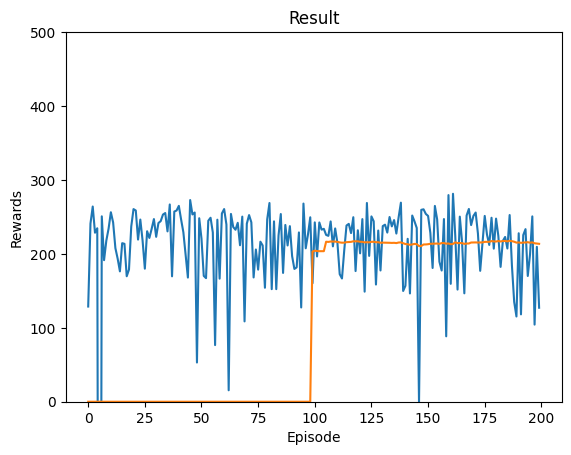

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

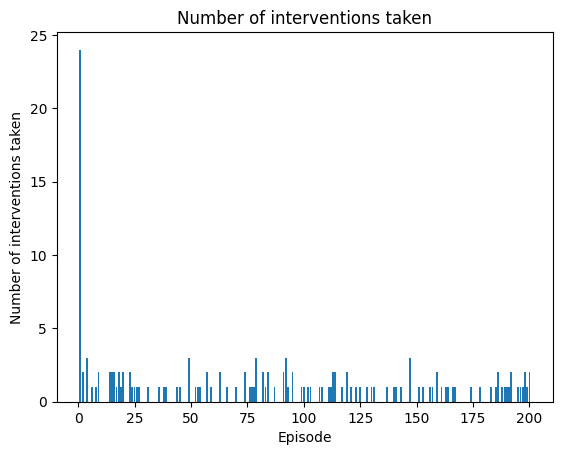

In [14]:
# Train the agent
num_steps_per_episode = 52 * 8

agent = DQN_agent(n_observations, n_actions, device, LR, GAMMA)
agent.train(training_episodes, step_look_back, num_steps_per_episode, \
            components, time_step, hyperparameters, x_init, \
            abnormal_ts_percentage, anomaly_range, \
            BATCH_SIZE, TAU, plot_samples, learning_curve_ylim = [0, 500])

# Testing

### Statistical comparison RL v.s. SKF

In [15]:
class SKF():
    # Run SKF on one time series
    def __init__(self, synthetic_timestamps, synthetic_observations):
        self.synthetic_timestamps = synthetic_timestamps
        self.synthetic_observations = synthetic_observations

    def import_configuration(self, configuration):
        self.LT_sigma_w = configuration["LT_sigma_w"]
        self.LA_sigma_w = configuration["LA_sigma_w"]
        self.KR_p = configuration["KR_p"]
        self.KR_ell = configuration["KR_ell"]
        self.KR_sigma_w = configuration["KR_sigma_w"]
        self.KR_sigma_hw = configuration["KR_sigma_hw"]
        self.AR_phi = configuration["AR_phi"]
        self.AR_sigma_w = configuration["AR_sigma_w"]
        self.sigma_v = configuration["sigma_v"]
        self.X_init = configuration["X_init"]
        self.V_init = configuration["V_init"]
        self.Z_11 = configuration["Z_11"]
        self.Z_22 = configuration["Z_22"]
        self.pi_1 = configuration["pi_1"]
        self.pi_2 = configuration["pi_2"]
        self.isBounded = configuration["isBounded"]
        self.BAR_gamma_value = configuration["BAR_gamma_value"]
        self.sigma_12 = configuration["sigma_12"]

    def get_alarm(self):
        # Set BAR option
        options_BAR = [self.AR_phi, self.AR_sigma_w**2, self.BAR_gamma_value]

        # Get reference time step
        timestep_values, timestep_counts = np.unique(np.diff(self.synthetic_timestamps), return_counts=True)
        timestep_ref = timestep_values[np.argmax(timestep_counts)]

        num_hidden_state = len(self.X_init)

        # Initiation
        ## mu
        mu = np.vstack((self.X_init, self.X_init))
        ## cov
        cov = np.vstack((self.V_init, self.V_init))
        cov = cov.reshape((2, num_hidden_state, num_hidden_state))

        # Array to fill
        ## Probability of non-stationary regime
        prob_ns_regime = np.zeros_like(self.synthetic_timestamps, dtype=float)

        # Probability of being at a regime
        pi = np.array([self.pi_1,self.pi_2])
        Z_12 = 1-self.Z_11
        Z_21 = 1-self.Z_22
        Z = np.array([[self.Z_11, Z_12],[Z_21, self.Z_22]])

        R = np.array([self.sigma_v**2, self.sigma_v**2, self.sigma_v**2, self.sigma_v**2]).reshape((2, 2, 1))
        L_t = np.zeros((2,2), dtype=tuple)

        KR_xcontrol=self.X_init[3:14]

        # Run
        y_pred = np.zeros_like(self.synthetic_observations, dtype=float)
        x_mu = np.zeros((len(self.synthetic_observations), 15))
        x_var = np.zeros((len(self.synthetic_observations), 15))
        for i in range(len(self.synthetic_timestamps)):
            timestep = 1

            ### Model 1
            LTcA_A, LTcA_C, LTcA_Q = LA_design_matrix(self.LT_sigma_w * np.sqrt(timestep/timestep_ref), timestep)
            LTcA_A[:,2] = 0

            ### Model 2
            LA_A, LA_C, LA_Q = LA_design_matrix(self.LA_sigma_w * np.sqrt(timestep/timestep_ref), timestep)

            KR_A, KR_C, KR_Q = KR_design_matrix(self.KR_sigma_hw*np.sqrt(timestep/timestep_ref), self.KR_sigma_w*np.sqrt(timestep/timestep_ref), self.KR_p, self.KR_ell, self.synthetic_timestamps[i], self.synthetic_timestamps[0], len(KR_xcontrol)-1)
            AR_A, AR_C, AR_Q = AR_design_matrix(self.AR_sigma_w * np.sqrt(timestep/timestep_ref), self.AR_phi ** (timestep/timestep_ref))

            # Assemble A, C, Q, R
            A_s = scipy.linalg.block_diag(LTcA_A,KR_A,AR_A)
            Q_s_s = scipy.linalg.block_diag(LTcA_Q,KR_Q,AR_Q)
            Q_s_ns = scipy.linalg.block_diag(LTcA_Q,KR_Q,AR_Q)
            Q_s_ns[2][2] = self.sigma_12

            A_ns = scipy.linalg.block_diag(LA_A,KR_A,AR_A)
            Q_ns_ns = scipy.linalg.block_diag(LA_Q,KR_Q,AR_Q)
            Q_ns_s = scipy.linalg.block_diag(LA_Q,KR_Q,AR_Q)

            C = np.hstack((LTcA_C,KR_C,AR_C))

            A = np.vstack((A_s,A_s,A_ns,A_ns)).reshape((2, 2, num_hidden_state, num_hidden_state))
            Q = np.vstack((Q_s_s,Q_s_ns,Q_ns_s,Q_ns_ns)).reshape((2, 2, num_hidden_state, num_hidden_state))
            C = np.vstack((C,C,C,C)).reshape((2, 2, num_hidden_state))

            mu,cov,pi,L_t,mu_pred,var_pred = merge_SKF(mu, cov, pi, L_t, A, C, Q, R, self.synthetic_observations[i], \
                                                       Z, self.isBounded, options_BAR)

            prob_ns_regime[i] = pi[1]

            y_pred[i] = mu_pred@C[0,0].T
            x_mu[i] = mu_pred
            x_var[i] = var_pred

        return prob_ns_regime, x_mu, x_var, y_pred


def f1t_evaluation(take_action, anomaly_magnitudes, components, hyperparameters, x_init,
                   device, num_steps, time_step,
                   use_real_data = False, real_timestamps = [], real_observations = [],
                   reps = 50, compare_with_skf = False, step_look_back = 64):
    '''
    This function evaluates the performance of the intervention policy using F1t score
    Inputs:
    - take_action: the function that action taken at each time step
    - anomaly_range: the range of the anomaly
    '''
    from tqdm import tqdm
    f1t_all = []
    f1t_skf_all = []
    detection_window_len = int(num_steps/2)
    for i, anomaly in enumerate(tqdm(anomaly_magnitudes)):
        false_positive = 0
        true_positive = 0
        false_negative = 0
        delta_t_all = []
        false_negative_skf = 0
        false_positive_skf = 0
        true_positive_skf = 0

        delta_t_all_skf = []
        for rep in range(reps):
            anomaly_pos = np.random.randint(step_look_back, int(num_steps/2))
            if use_real_data:
                syn_ts = insert_anomalies(timestamps = real_timestamps, observations = real_observations, \
                                        time_step = time_step, anomaly_timesteps = [anomaly_pos], anomaly_LT = [anomaly])
            else:
                syn_ts = generate_time_series_0(components, time_step, hyperparameters, num_steps, x_init, \
                                            anm_timestep = anomaly_pos,\
                                            anm_LT = anomaly)

            if compare_with_skf:
                ################################# Baseline SKF #################################
                SKF_class=SKF(syn_ts['timesteps'], syn_ts['y'])

                configuration_skf_bar = {
                        "LT_sigma_w": 0,
                        "LA_sigma_w": 0,
                        "KR_p": 365.2422/7,
                        "KR_ell": 0.58491,
                        "KR_sigma_w": 0,
                        "KR_sigma_hw": 0,
                        "AR_phi": 0.75867,
                        "AR_sigma_w": 0.11453,
                        "sigma_v": 0.001,
                        "X_init": np.array([1.37, -1.19E-05, 0, 0, -1.2, -0.822, -2.01, 0.292, 1.68, 1.85, 1.96, 0.568, -1.44, -0.88, -0.516]),
                        "V_init": np.diag([0.111, 2.88E-09, 1e-15, 1.1, 0.278, 0.273, 0.276, 0.281, 0.284, 0.288, 0.284, 0.283, 0.282, 0.281, 0.0346]),
                        "Z_11": 0.9999999,
                        "Z_22": 0.9999999,
                        "pi_1": 0.999,
                        "pi_2": 0.001,
                        "isBounded": False,
                        "BAR_gamma_value": 0,
                        "sigma_12": 1e-06
                        }

                SKF_class.import_configuration(configuration_skf_bar)

                prob_ns_regime, x_mu, x_var, y_mu = SKF_class.get_alarm()

                # Update metrics
                TP, FP, FN, delta_t = get_TP_FP_FN(prob_ns_regime, anomaly_pos, detection_window_len)
                true_positive_skf += TP
                false_positive_skf += FP
                false_negative_skf += FN
                if delta_t is not None:
                    delta_t_all_skf.append(delta_t)

            ################################# RL-based intervention #################################
            # Set the dataset for the environment
            i_ts_datasets = {
                'measurement': syn_ts['y'],
                'time_step': time_step,
                'timestamps': syn_ts['timesteps'],
                'components': components,
                'hyperparameters': hyperparameters,
                'initial_states': x_init,
            }
            env = KalmanInterventionEnv(render_mode=None, time_series_datasets=i_ts_datasets, step_look_back = step_look_back, hyperparameters=hyperparameters, smoothing_length=0)
            state, info = env.reset()
            intervention_taken = False
            AR_std_stationary = np.sqrt(hyperparameters['ar']['process_error_var']/(1-hyperparameters['ar']['phi']**2))
            if step_look_back == 64:
                seg_len = 8
            for t in count():
                # state = torch.tensor(np.hstack((state['KF_hidden_states'], intervention_taken)),\
                #                     dtype=torch.float32, device=device).unsqueeze(0)
                print_info = False
                if np.isnan(state['KF_hidden_states']).any():
                    print_info = True
                    print('nan is network input')
                state = torch.tensor(state['KF_hidden_states'],\
                                    dtype=torch.float32, device=device).unsqueeze(0)
                state = normalize_tensor_two_parts(state, 0, np.sqrt(LA_var_stationary),\
                                                    0, AR_std_stationary, seg_len)
                action = take_action(state = state, greedy=True)
                if print_info:
                    print('action is', action)
                state, _, terminated, truncated, _ = env.step(action.item())

                done = terminated or truncated

                if action.item() == 1:
                    if t < anomaly_pos - step_look_back - 1:
                        false_positive += 1
                        done = True
                        delta_t = 0
                        delta_t_all.append(delta_t)
                    elif t >= anomaly_pos - step_look_back - 1 and t <= anomaly_pos + detection_window_len - step_look_back - 1:
                        true_positive += 1
                        # record triggering time
                        done = True
                        delta_t = t + step_look_back + 1 - anomaly_pos
                        delta_t_all.append(delta_t)
                    else:
                        done = True
                        false_negative += 1
                    intervention_taken = True

                if done:
                    if not intervention_taken:
                        false_negative += 1
                    break

        # Compute the f1 score
        if true_positive == 0:
            f1 = 0
        else:
            precision = true_positive/(true_positive+false_positive)
            recall = true_positive/(true_positive+false_negative)
            f1 = 2*precision*recall/(precision+recall)

        # # Compute f1 score for skf
        f1_skf = compute_f1(true_positive_skf, false_positive_skf, false_negative_skf)

        avg_delta_t = np.mean(delta_t_all)
        avg_delta_t_skf = np.mean(delta_t_all_skf)
        # Compute the penalty ratio linearly decay from 1 (avg_delta_t <= 0) to 0 (avg_delta_t = num_steps - anomaly_pos)
        penalty_ratio = 1 - avg_delta_t/detection_window_len
        penalty_ratio_skf = 1 - avg_delta_t_skf/detection_window_len

        f1t = f1*penalty_ratio
        f1t_skf = f1_skf*penalty_ratio_skf

        f1t_all.append(f1t)
        f1t_skf_all.append(f1t_skf)

        print(f'Anomaly magnitude: {anomaly}')
        print('RL:', true_positive, false_positive, false_negative, penalty_ratio)
        print('SKF:', true_positive_skf, false_positive_skf, false_negative_skf, penalty_ratio_skf)
    return anomaly_magnitudes, f1t_all, f1t_skf_all

In [16]:
# Evaluate agent's performance
timeseries_duration = 52 * 8
num_steps = int(np.round(timeseries_duration/time_step))
anomaly_magnitudes, f1t_all, f1t_skf_all, = f1t_evaluation(\
                                                take_action = agent.select_action, \
                                                anomaly_magnitudes = [0.00, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.02],\
                                                components = components, hyperparameters = hyperparameters, x_init = x_init, \
                                                device = device, num_steps = num_steps, time_step = time_step, \
                                                use_real_data = False, real_timestamps = resample_timestamps, real_observations = resample_observations, \
                                                reps = 50, compare_with_skf = False, step_look_back = step_look_back)


  0%|          | 0/7 [00:00<?, ?it/s]/Users/zhanwenxin/miniconda3/envs/pytagi_lstm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zhanwenxin/miniconda3/envs/pytagi_lstm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 14%|█▍        | 1/7 [00:21<02:08, 21.34s/it]

Anomaly magnitude: 0.0
RL: 0 0 50 nan
SKF: 0 0 0 nan


 29%|██▊       | 2/7 [00:43<01:47, 21.60s/it]

Anomaly magnitude: 0.0005
RL: 1 0 49 0.043269230769230727
SKF: 0 0 0 nan


 43%|████▎     | 3/7 [01:02<01:22, 20.72s/it]

Anomaly magnitude: 0.001
RL: 14 0 36 0.11675824175824168
SKF: 0 0 0 nan


 57%|█████▋    | 4/7 [01:19<00:57, 19.16s/it]

Anomaly magnitude: 0.003
RL: 43 0 7 0.43079159212880147
SKF: 0 0 0 nan


 71%|███████▏  | 5/7 [01:33<00:34, 17.14s/it]

Anomaly magnitude: 0.005
RL: 49 0 1 0.5720172684458399
SKF: 0 0 0 nan


 86%|████████▌ | 6/7 [01:46<00:15, 15.78s/it]

Anomaly magnitude: 0.01
RL: 50 0 0 0.7520192307692308
SKF: 0 0 0 nan


100%|██████████| 7/7 [01:58<00:00, 16.86s/it]

Anomaly magnitude: 0.02
RL: 50 0 0 0.83125
SKF: 0 0 0 nan


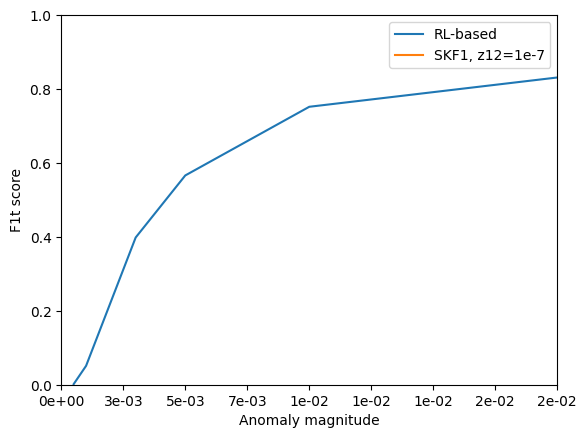

In [17]:
plt.plot(anomaly_magnitudes, f1t_all, label = 'RL-based')
plt.plot(anomaly_magnitudes, f1t_skf_all, label = 'SKF1, z12=1e-7')
# Set the digits after the decimal point in the x-axis
from matplotlib.ticker import FormatStrFormatter
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.0e'))
# set x axis begin from 0
plt.xlim(0, 0.02)
plt.xlabel('Anomaly magnitude')
plt.ylabel('F1t score')
plt.ylim(0,1)
plt.legend()
plt.show()

### Time series sample

In [18]:
def interact_Q_visualization(agent_pos = 200, seed=21, anm_mag = 0):
    anm_mag = anm_mag/1000
    num_steps = len(resample_timestamps)
    np.random.seed(seed)

    # Randomly sample an integer between num_steps/4 and num_steps/2
    anomaly_pos = 0
    anomaly_pos2 = 50

    syn_ts = insert_anomalies(timestamps = resample_timestamps, observations = resample_observations, \
                                      time_step = time_step, anomaly_timesteps = [anomaly_pos, anomaly_pos2], anomaly_LT = [0, anm_mag])

    ################################# Baseline SKF #################################
    SKF_class=SKF(ts_model_check['timesteps'], syn_ts['y'])

    configuration_skf_bar = {
            "LT_sigma_w": 0,
            "LA_sigma_w": 0,
            "KR_p": hyperparameters['kernel']['period'],
            "KR_ell": hyperparameters['kernel']['kernel_length'],
            "KR_sigma_w": 0,
            "KR_sigma_hw": 0,
            "AR_phi": hyperparameters['ar']['phi'],
            "AR_sigma_w": np.sqrt(hyperparameters['ar']['process_error_var']),
            "sigma_v": hyperparameters['observation']['error'],
            "X_init": x_init['mu'],
            "V_init": x_init['var'],
            "Z_11": 0.9999999,
            "Z_22": 0.9999999,
            "pi_1": 0.999,
            "pi_2": 0.001,
            "isBounded": False,
            "BAR_gamma_value": 0,
            "sigma_12": 1e-06
            }

    SKF_class.import_configuration(configuration_skf_bar)

    prob_ns_regime, x_mu, x_var, y_mu = SKF_class.get_alarm()
    # Get the all indices where prob_ns_regime is bigger than 0.5
    skf_triggers = np.where(prob_ns_regime > 0.5)[0]

    ################################# RL #################################
    # Set the dataset for the RL environment
    dummy_ts_datasets = {
                'measurement': syn_ts['y'],
                'time_step': time_step,
                'timestamps': ts_model_check['timesteps'],
                'components': components,
                'hyperparameters': hyperparameters,
                'initial_states': x_init,
            }

    # Create the environment
    total_reward = 0
    env = KalmanInterventionEnv(render_mode=None, time_series_datasets=dummy_ts_datasets, step_look_back = step_look_back, hyperparameters=hyperparameters, smoothing_length=0)

    steps_lb = env._get_look_back_time_steps(agent_pos)

    state, info = env.reset()
    intervention_index =[]
    intervention_taken = False
    AR_std_stationary = np.sqrt(hyperparameters['ar']['process_error_var']/(1-hyperparameters['ar']['phi']**2))
    if step_look_back == 64:
        seg_len = 8
    for i in range(num_steps - step_look_back - 1):
        state = torch.tensor(state['KF_hidden_states'],\
                            dtype=torch.float32, device=device).unsqueeze(0)
        state = normalize_tensor_two_parts(state, 0, np.sqrt(LA_var_stationary),\
                                            0, AR_std_stationary, seg_len)
        action = agent.select_action(state, greedy=True)
        action = action.item()

        if i  == agent_pos - step_look_back:
            print('Q (s, a = no interv.):',float(agent.policy_net(state)[0, 0]))
            print('Q (s, a = interv.):',float(agent.policy_net(state)[0, 1]))

        state, reward, _, _, info = env.step(action)


        if action == 1:
            intervention_index.append(i + step_look_back + 1)
            intervention_taken = True
        total_reward += reward

    # Plot prediction
    from matplotlib import gridspec
    fig = plt.figure(figsize=(15, 12))
    gs = gridspec.GridSpec(5, 1)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])
    ax3 = plt.subplot(gs[3])
    ax4 = plt.subplot(gs[4])


    for count, i in enumerate(skf_triggers):
        if count == 0:
            ax0.axvline(x=ts_model_check['timesteps'][i], color='b', alpha=0.05, linestyle='--', label='SKF triggers')
        else:
            ax0.axvline(x=ts_model_check['timesteps'][i], color='b', alpha=0.05,linestyle='--')

    ax0.plot(ts_model_check['timesteps'], syn_ts['y'], label='True')
    ax0.plot(ts_model_check['timesteps'], info['y_pred']['mu'], label='Predicted')
    if anm_mag != 0:
        ax0.axvline(x=ts_model_check['timesteps'][anomaly_pos2], color='gray', linestyle='--', label='Anomaly begin')

    for count, i in enumerate(intervention_index):
        if count == 0:
            ax0.axvline(x=ts_model_check['timesteps'][i], color='r', linestyle='--', label='RL triggers')
        else:
            ax0.axvline(x=ts_model_check['timesteps'][i], color='r', linestyle='--')
    ax0.plot(ts_model_check['timesteps'], info['hidden_states']['mu'][:,0], color = 'k',alpha=0.4, label='LL')
    ax0.fill_between(ts_model_check['timesteps'], info['hidden_states']['mu'][:,0] - np.sqrt(info['hidden_states']['var'][:,0,0]),\
                        info['hidden_states']['mu'][:,0] + np.sqrt(info['hidden_states']['var'][:,0,0]), color='gray', alpha=0.2)
    ax0.set_ylabel('y')
    handles, labels = ax0.get_legend_handles_labels()
    ax0.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.07,1))


    ax1.plot(ts_model_check['timesteps'], info['hidden_states']['mu'][:,2], label='LA')
    ax1.fill_between(ts_model_check['timesteps'], info['hidden_states']['mu'][:,2] - np.sqrt(info['hidden_states']['var'][:,2,2]),\
                        info['hidden_states']['mu'][:,2] + np.sqrt(info['hidden_states']['var'][:,2,2]), color='gray', alpha=0.2)
    for step in steps_lb:
        ax1.scatter(ts_model_check['timesteps'][step], info['hidden_states']['mu'][step,2], color='r', s=15)
    ax1.set_ylabel('LA')

    AR_var_stationary = hyperparameters['ar']['process_error_var']/(1-hyperparameters['ar']['phi']**2)
    ax2.fill_between(ts_model_check['timesteps'], np.zeros_like(syn_ts['timesteps'])-3*np.sqrt(AR_var_stationary), np.zeros_like(syn_ts['timesteps'])+3*np.sqrt(AR_var_stationary), color='red', alpha=0.1)
    ax2.plot(ts_model_check['timesteps'], info['hidden_states']['mu'][:,-1], label='AR')
    ax2.fill_between(ts_model_check['timesteps'], info['hidden_states']['mu'][:,-1] - np.sqrt(info['hidden_states']['var'][:,-1,-1]),\
                        info['hidden_states']['mu'][:,-1] + np.sqrt(info['hidden_states']['var'][:,-1,-1]), color='gray', alpha=0.2)
    for step in steps_lb:
        ax2.scatter(ts_model_check['timesteps'][step], info['hidden_states']['mu'][step,-1], color='r', s=15)
    ax2.set_ylabel('AR')

    ax3.plot(ts_model_check['timesteps'], info['hidden_states']['mu'][:,1], label='LT')
    ax3.fill_between(ts_model_check['timesteps'], info['hidden_states']['mu'][:,1] - np.sqrt(info['hidden_states']['var'][:,1,1]),\
                        info['hidden_states']['mu'][:,1] + np.sqrt(info['hidden_states']['var'][:,1,1]), color='gray', alpha=0.2)
    ax3.set_ylabel('LT')

    ax4.plot(ts_model_check['timesteps'], info['hidden_states']['mu'][:,3], label='KR')
    ax4.fill_between(ts_model_check['timesteps'], info['hidden_states']['mu'][:,3] - np.sqrt(info['hidden_states']['var'][:,3,3]),\
                        info['hidden_states']['mu'][:,3] + np.sqrt(info['hidden_states']['var'][:,3,3]), color='gray', alpha=0.2)
    ax4.set_ylabel('KR')
    ax4.set_xlabel('Time steps')
    plt.show()

In [19]:
import ipywidgets
ipywidgets.interact(interact_Q_visualization, agent_pos = (64, 2890, 1), seed = (0, 100, 1), anm_mag = (0, 10, 1))

interactive(children=(IntSlider(value=200, description='agent_pos', max=2890, min=64), IntSlider(value=21, des…

<function __main__.interact_Q_visualization(agent_pos=200, seed=21, anm_mag=0)>